In [1]:
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

Исходные данные представляют собой информацию о потреблении электричской энергии в ОЭС Беларуси и температуре наружного воздуха на ТЭЦ-3, расположенной в городе Минске. Данные собраны с 2016 года и представляют собой файлы формата .xlsx со значениями. Значения представляют собой абсолютное значения измерения на начало каждой минуты. Помимо этих измерений в файлах назодится аналогичный .xlsx файл с почасовыми интегральными значениями потребления энергии. У этой информации имеются некоторые особенности:

1. Все значения промаркированы концом часа, что логично вытекает из происхождения данной информации. Среднечасовое значения потребления становится известным к концу часа.
2. Данные о потреблении не включают в себя одну специальную группу потребителей. С декабря 2020 года в энергосистеме установлены электрические котлы, потребление которых запланировано. Их нагрузка определяется исходя из ожидаемого (прогнозируемого) уровня потребления энергии всеми остальными (неуправляемыми) потребителями.
3. Среднечасовое полное потребление из годовых файлов .xlsx меньше или примерно равно интегральным значениям. Включение электрокотлов преимущественно происходит в ночные часы.

В связи с этим исходные должны быть подготовлены следующим образом:

1. Принятая временная резолюция должна равняться интервалу оперативного планирования, который составляет один час.
2. Данные должны быть промечены на начало каждого часа. Это значит, например, что среднечасовая температура воздуха с 13:00 до 14:00 часов дня должна иметь временную метку 13:00. А суточное потребление должно быть отражено в 24 строках датафрейма начиная от 00:00 и до 23:00 часов следующих суток. Это позволит сохранить принадлежность всех значений к одним суткам при группировке.
3. В данных о потреблении не должно быть нагрузки от электрических котлов.

In [2]:
filename_list = os.listdir('data_for_train')
regex = r"^[0-9]+\.xlsx$"
valid_filename_list = [filename for filename in filename_list if re.match(regex, filename)]
valid_filename_list

['2016.xlsx',
 '2017.xlsx',
 '2018.xlsx',
 '2019.xlsx',
 '2020.xlsx',
 '2021.xlsx',
 '2022.xlsx',
 '2023.xlsx']

In [4]:
df = pd.read_excel('data_for_train/' + valid_filename_list[0],
                   names=['datetime', 'one_minute_consumption', 'one_minute_temperature'],
                   skiprows=3)
df.shape

(527040, 3)

In [5]:
for file in tqdm(valid_filename_list[1:]):
    temp_df = pd.read_excel('data_for_train/' + file,
                   names=['datetime', 'one_minute_consumption', 'one_minute_temperature'],
                   skiprows=3)
    df = pd.concat([df, temp_df], ignore_index=True)

df.set_index('datetime', inplace=True)
print('df.shape', df.shape)
df.head(2)

  0%|          | 0/7 [00:00<?, ?it/s]

df.shape (3899520, 2)


,one_minute_consumption,one_minute_temperature
datetime,,
2016-01-01 00:00:00,3913.0,-8.4
2016-01-01 00:01:00,3913.0,-8.4


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3899520 entries, 2016-01-01 00:00:00 to 2023-05-31 23:59:00
Data columns (total 2 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   one_minute_consumption  float64
 1   one_minute_temperature  float64
dtypes: float64(2)
memory usage: 89.3 MB


"Посмотрим" на значения измерений:

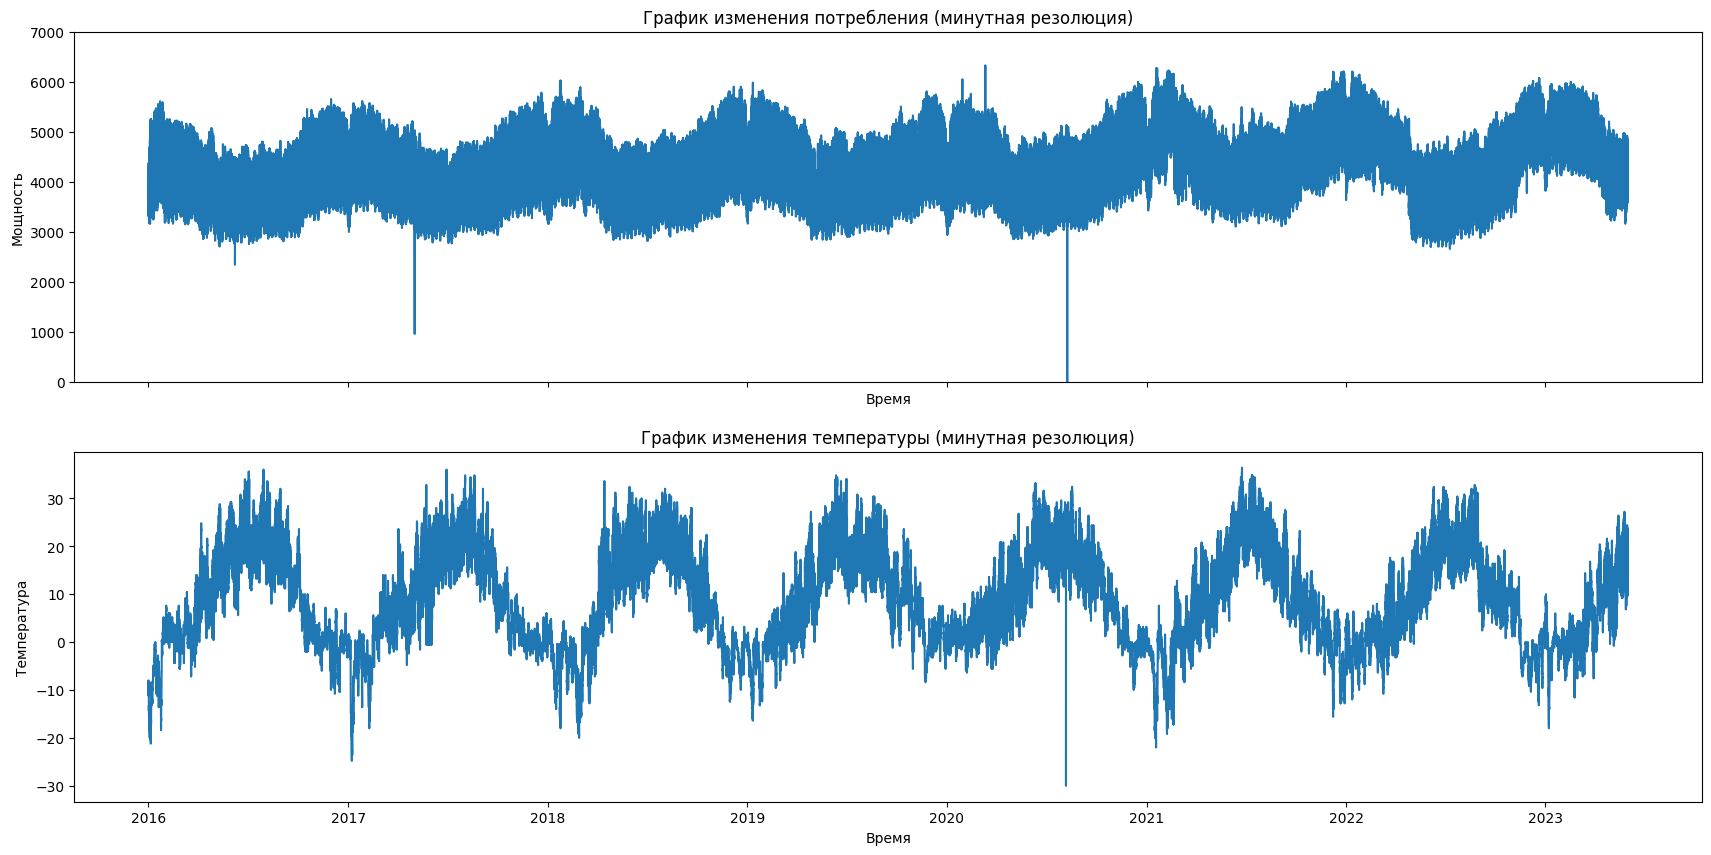

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(21, 10), sharex=True)

ax1.plot(df['one_minute_consumption'])
ax1.set_xlabel('Время')
ax1.set_ylabel('Мощность'),
ax1.set_ylim([0, 7000])
ax1.set_title('График изменения потребления (минутная резолюция)')

ax2.plot(df['one_minute_temperature'])
ax2.set_xlabel('Время')
ax2.set_ylabel('Температура')
ax2.set_title('График изменения температуры (минутная резолюция)')

plt.show()

Визуально данные имеют как минимум по одному серьёзному выбросу за всю историю наблюдений, который может быть связан с отказом датчика или другим глюком, из-за чего значение автоматически приняло минимальное значение шкалы. Отловим такие ошибки по стремительному изменению мощности или температуры в двух соседних значениях:

In [8]:
df_diff = np.abs(df.diff())
df_diff.rename(columns={'one_minute_consumption': 'one_minute_consumption_diff',
                        'one_minute_temperature': 'one_minute_temperature_diff'},
                        inplace=True)
df_diff.describe(percentiles=[.25, .75, .99, .999]).T

,count,mean,std,min,25%,50%,75%,99%,99.9%,max
one_minute_consumption_diff,3899519.0,1.797532e+06,2.509927e+09,0.0,4.0,16.0,36.427979,122.000000,179.000000,3.504706e+12
one_minute_temperature_diff,3899519.0,8.010619e-02,1.973654e-01,0.0,0.0,0.0,0.000000,0.400002,0.800001,5.300000e+01


Выбрасывать значения например при помощи метода 1,5 межквартильных размаха не стоит, так как значения, соответсвующие .001 и .999 квартилям также вполне возможны и реальны. Выбросим те значения, которые отстоят от .01 и .99 персентилей на расстоянии большем, чем размах между этими персентилями. Посмотрим на них визуально:

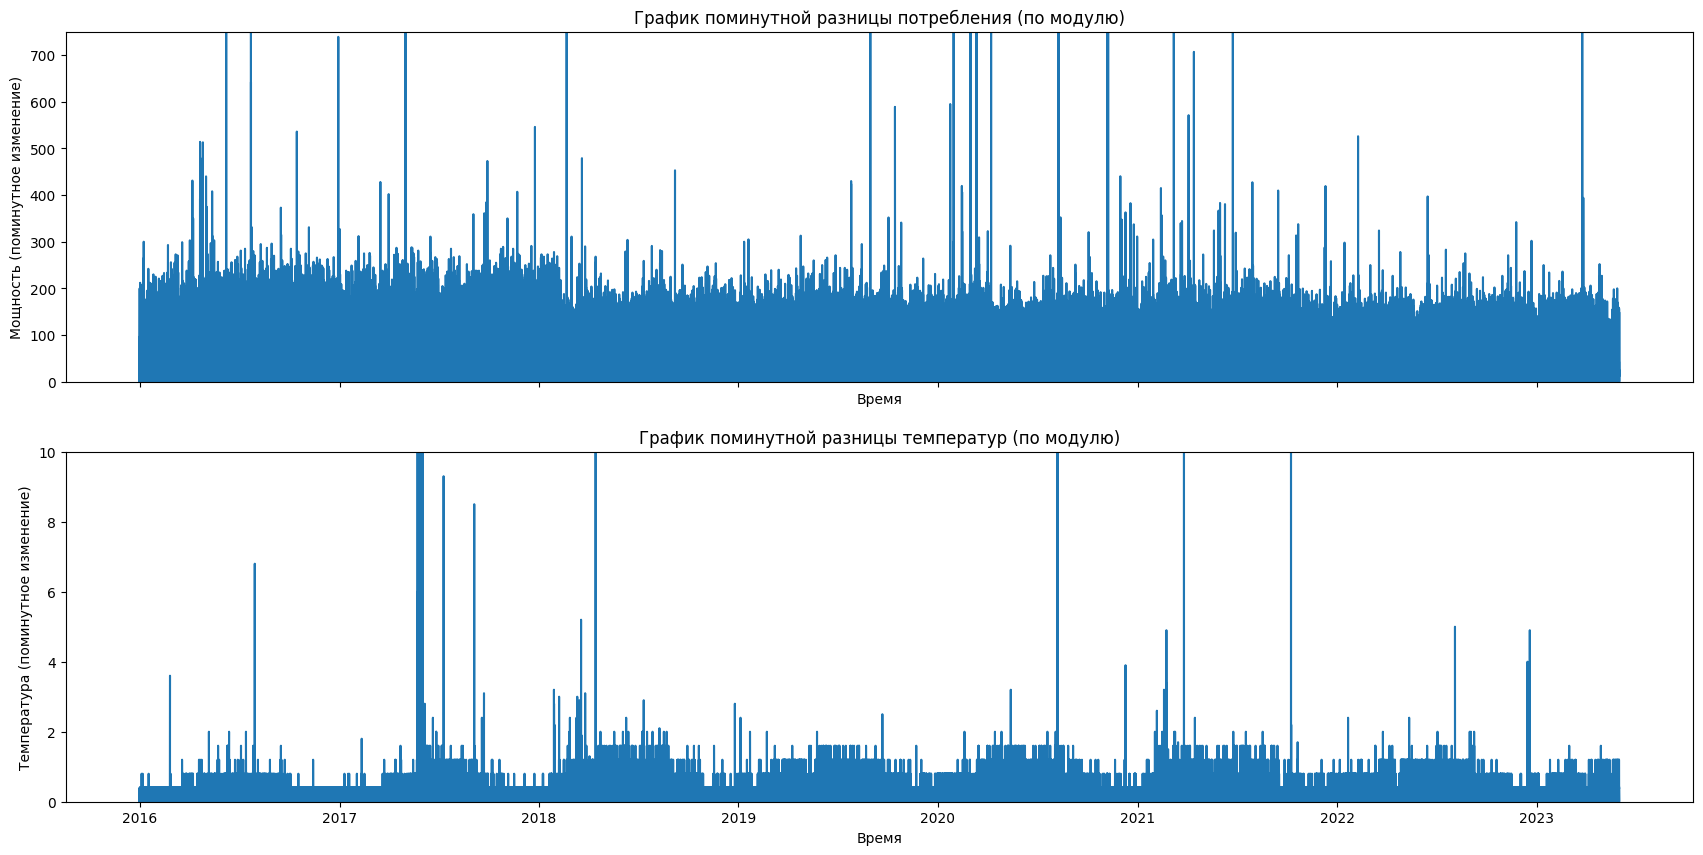

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(21, 10), sharex=True)

ax1.plot(df_diff['one_minute_consumption_diff'])
ax1.set_xlabel('Время')
ax1.set_ylabel('Мощность (поминутное изменение)')
ax1.set_ylim([0, 750])
ax1.set_title('График поминутной разницы потребления (по модулю)')

ax2.plot(df_diff['one_minute_temperature_diff'])
ax2.set_xlabel('Время')
ax2.set_ylabel('Температура (поминутное изменение)')
ax2.set_ylim([0, 10])
ax2.set_title('График поминутной разницы температур (по модулю)')

plt.show()

С учётом того, что поминутные данные в последствии будут усредняться до часовой резолюции, нам нужно избавиться только от жёстких бросков значений. Назовём значение выбросом, если изменение мощности на двух соседних измерениях превышает 350 МВт, а измерение температуры - свыше 2.5 градусов (всё по модулю)

Рассмотрим подробнее отдельные факты выброса. Когда на графике в одном или нескольких соседних моментах зафиксированы ошибочные значения, то в идеале на графике поминутных разниц мы увидим два соседних всплеска, первый из которых соответсвует началу выброса, а второй - моменту восстановления измерения. Таким образом нам нужно избавиться от всех значений от первого всплеска (включительно) и до второго (не включительно).

In [10]:
consumption_out = df_diff[df_diff['one_minute_consumption_diff'] > 300].loc[:,'one_minute_consumption_diff']
consumption_out.shape

(178,)

In [11]:
temperature_out = df_diff[df_diff['one_minute_temperature_diff'] > 2.5].loc[:,'one_minute_temperature_diff']
temperature_out.shape

(158,)

Проанализировав данные, я принял решение называть выбросом интревал значений, если оба пика (связанные с ростом/спадом и последующим спадом/ростом абсолютного значения) находятся друг от друга на расстоянии не более 10 минут. Тогда весь указанный интервал должен быть промаркирован как выброс, в обратном случае это не считается выбросом и значение остаётся как есть. Те значения, которые были выброшены, будут заменены предыдущим с помощью метода .ffill(). Если мы упустим какие-то значения, данная ошибка будет "прощена" на этапе усреднения знечений на часовом интервале.

Напишем функцию, которая будет принимать на вход датафрейм, колонку, минимальное отклонение, интревал времени и размерности, которые имеют индексы. Данная функция будет создавать маску индексов в формате DateTime, "обнулять" по ней значения датафрейма и вызывать метод .ffill()

In [12]:
def catch_time_series_outs(df: pd.DataFrame, col_name: str, min_diff: int, time_delta: int, freq: str) -> None:
    """
    df - датафейм с временными рядами
    col_name - имя колонки, в которой будем удалять аномалии
    min_diff - минимальное значение разницы двух соседних измерений, чтобы назвать его аномалией
    time_delta - максимальное время существования данной аномалии
    freq - временная частота индексов датафрейма (смотреть документацию по pandas.date_range)
    Некоторые из допустимых:
    H - hourly frequency
    min - minutely frequency
    S - secondly frequency

    Функция заменяет факты аномалии на np.nan и вызывает метод .ffill() у датафрейма
    """
    df_diff = np.abs(df.diff())
    out_series = df_diff[df_diff[col_name] > min_diff].loc[:,col_name]
    out_times = out_series.index
    out_indexis = pd.Series(dtype='datetime64[ns]')

    time_delta_dict = {'H': 'hour',
                       'min': 'min',
                       'S': 'sec'}

    for i in range(len(out_times) - 1):

        timediff = out_times[i+1] - out_times[i]
        timediff /= pd.Timedelta(value=1,
                                 unit = time_delta_dict[freq])

        if timediff <= time_delta:
            time_range = pd.Series(pd.date_range(start=out_times[i],
                                                end=out_times[i+1],
                                                freq=freq,
                                                inclusive='left'))

            out_indexis = pd.concat([out_indexis, time_range])
    
    df.loc[out_indexis, col_name] = np.nan
    df.ffill(inplace=True)

Применим функцию:

In [13]:
catch_time_series_outs(df=df,
                       col_name='one_minute_consumption',
                       min_diff=300,
                       time_delta=10,
                       freq='min')

In [14]:
catch_time_series_outs(df=df,
                       col_name='one_minute_temperature',
                       min_diff=2.5,
                       time_delta=10,
                       freq='min')

Взглянем на результат:

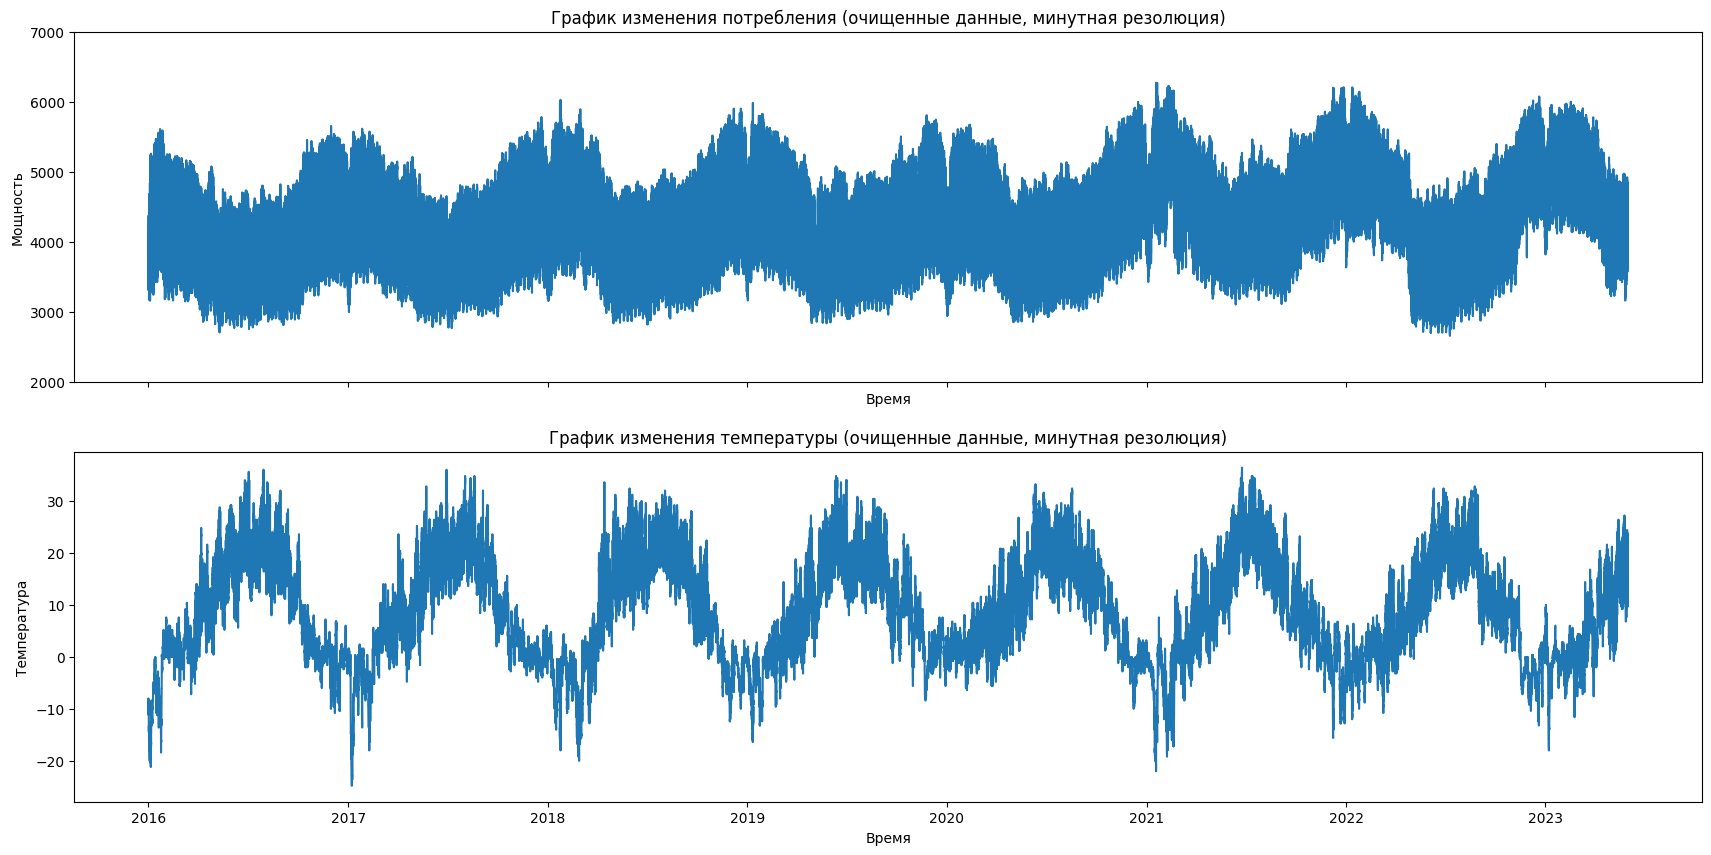

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(21, 10), sharex=True)

ax1.plot(df['one_minute_consumption'])
ax1.set_xlabel('Время')
ax1.set_ylabel('Мощность'),
ax1.set_ylim([2000, 7000])
ax1.set_title('График изменения потребления (очищенные данные, минутная резолюция)')

ax2.plot(df['one_minute_temperature'])
ax2.set_xlabel('Время')
ax2.set_ylabel('Температура')
ax2.set_title('График изменения температуры (очищенные данные, минутная резолюция)')

plt.show()

In [16]:
for col_name, col_values in df.items():
    print(f"< {col_name} >".center(100, "-"))
    print(f"Data type: {col_values.dtype}")
    print(f"Is unique: {col_values.is_unique}")
    print(f"% of Nones: {col_values.isna().mean()}")
    print(col_values.describe(percentiles=(.01, .25, .75, .99)).round(2))

-------------------------------------< one_minute_consumption >-------------------------------------
Data type: float64
Is unique: False
% of Nones: 0.0
count    3899520.00
mean        4326.51
std          655.53
min         2655.00
1%          3051.00
25%         3812.00
50%         4340.00
75%         4800.00
99%         5721.00
max         6271.10
Name: one_minute_consumption, dtype: float64
-------------------------------------< one_minute_temperature >-------------------------------------
Data type: float64
Is unique: False
% of Nones: 0.0
count    3899520.00
mean           8.16
std            9.76
min          -24.80
1%           -13.20
25%            0.40
50%            7.20
75%           16.00
99%           28.80
max           36.40
Name: one_minute_temperature, dtype: float64


Запишем эти данные в csv файл для сохранности.

In [17]:
df.to_csv('data_for_train/clean_minute_data.csv')

In [18]:
df = pd.read_csv('data_for_train/clean_minute_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
print('df.shape', df.shape)
df.head(2)

df.shape (3899520, 3)


,datetime,one_minute_consumption,one_minute_temperature
0,2016-01-01 00:00:00,3913.0,-8.4
1,2016-01-01 00:01:00,3913.0,-8.4


Сгруппируем данные по каждому часу:

In [19]:
group_df = df.groupby(df['datetime'].dt.strftime("%Y-%m-%d %H:00:00")).mean(numeric_only=True)
group_df.rename(columns={'one_minute_consumption': 'one_hour_consumption',
                         'one_minute_temperature': 'one_hour_temperature'},
                        inplace=True)
print('group_df.shape', group_df.shape)
group_df.head(2)

group_df.shape (64992, 2)


,one_hour_consumption,one_hour_temperature
datetime,,
2016-01-01 00:00:00,3962.983333,-8.313333
2016-01-01 01:00:00,3808.266667,-8.260000


Запишем эти данные также в csv файл для сохранности.

In [20]:
group_df.to_csv('data_for_train/clean_hour_data.csv')

Далее мы будем работать с этим датафреймом. Назовём его именем df.

In [21]:
df = pd.read_csv('data_for_train/clean_hour_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df.set_index('datetime', inplace=True)
print('df.shape', df.shape)
df.head(2)

df.shape (64992, 2)


,one_hour_consumption,one_hour_temperature
datetime,,
2016-01-01 00:00:00,3962.983333,-8.313333
2016-01-01 01:00:00,3808.266667,-8.260000


Осмотримся:

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64992 entries, 2016-01-01 00:00:00 to 2023-05-31 23:00:00
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   one_hour_consumption  64992 non-null  float64
 1   one_hour_temperature  64992 non-null  float64
dtypes: float64(2)
memory usage: 1.5 MB


In [23]:
for col_name, col_values in df.items():
    print(f"< {col_name} >".center(100, "-"))
    print(f"Data type: {col_values.dtype}")
    print(f"Is unique: {col_values.is_unique}")
    print(f"% of Nones: {col_values.isna().mean()}")
    print(col_values.describe(percentiles=(.01, .25, .75, .99)).round(2))

--------------------------------------< one_hour_consumption >--------------------------------------
Data type: float64
Is unique: False
% of Nones: 0.0
count    64992.00
mean      4326.51
std        651.33
min       2770.98
1%        3064.04
25%       3813.21
50%       4339.65
75%       4796.26
99%       5714.27
max       6167.18
Name: one_hour_consumption, dtype: float64
--------------------------------------< one_hour_temperature >--------------------------------------
Data type: float64
Is unique: False
% of Nones: 0.0
count    64992.00
mean         8.16
std          9.75
min        -24.41
1%         -13.37
25%          0.48
50%          7.39
75%         15.99
99%         28.69
max         35.15
Name: one_hour_temperature, dtype: float64


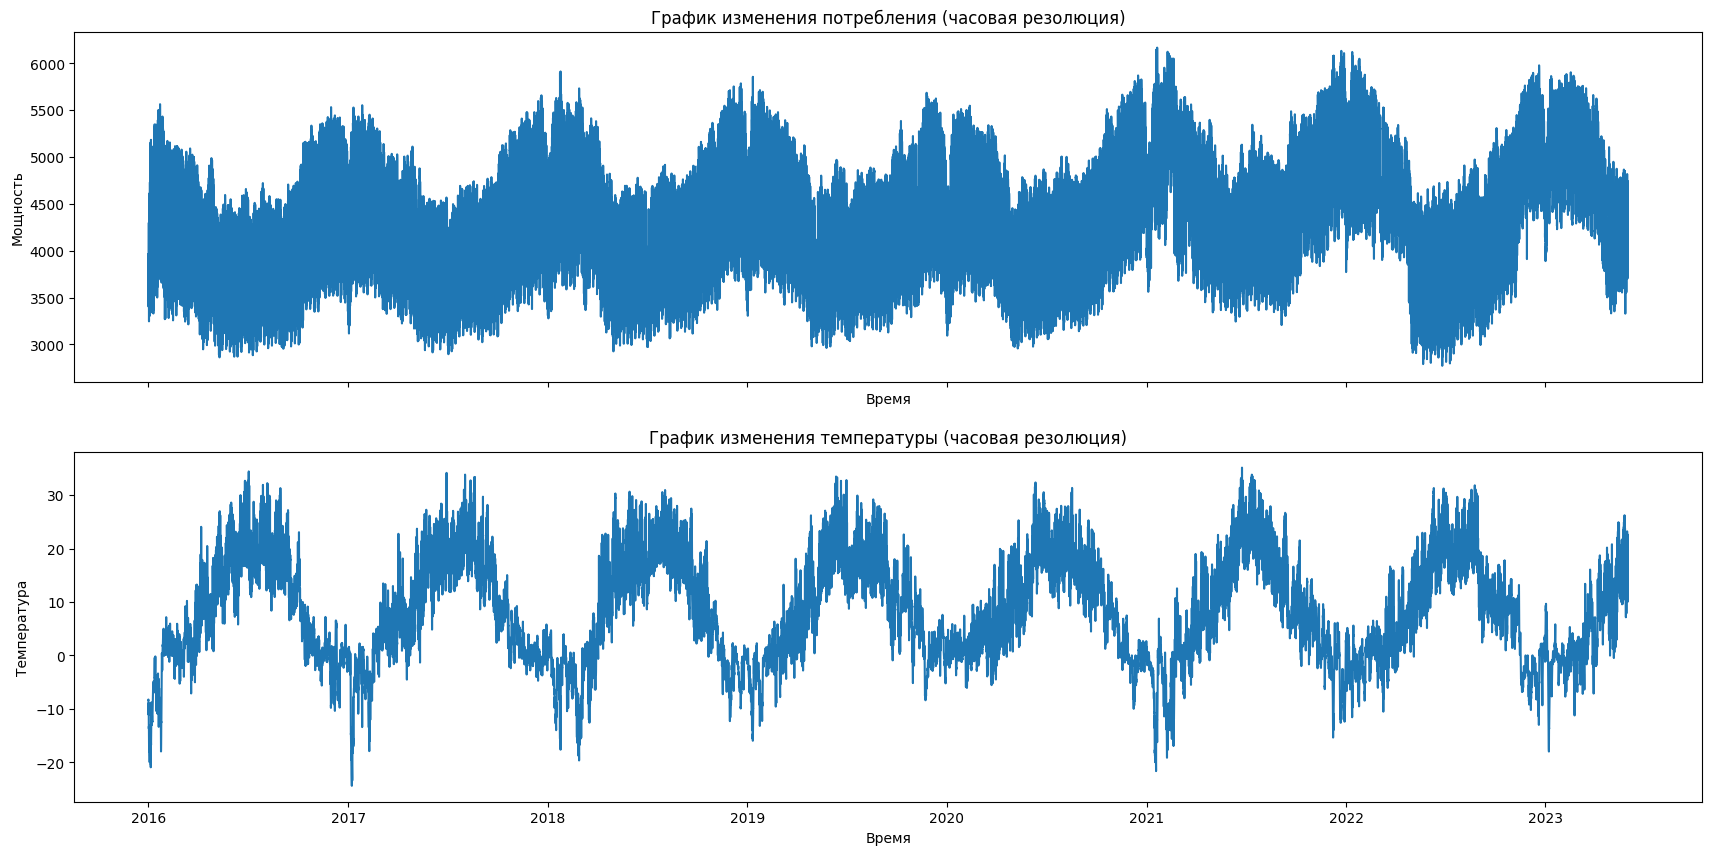

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(21, 10), sharex=True)

ax1.plot(df['one_hour_consumption'])
ax1.set_xlabel('Время')
ax1.set_ylabel('Мощность')
ax1.set_title('График изменения потребления (часовая резолюция)')

ax2.plot(df['one_hour_temperature'])
ax2.set_xlabel('Время')
ax2.set_ylabel('Температура')
ax2.set_title('График изменения температуры (часовая резолюция)')

plt.show()

Прочитаем файл с данными по потреблению электроэнергии без учёта особой группы:

In [25]:
boiler_df = pd.read_excel('data_for_train/2018-12-24 - 2023(without_boiler_integral).xlsx',
                          names=['datetime', 'one_hour_consumption_without_boiler'],
                          skiprows=3)
boiler_df = boiler_df.set_index('datetime')
print('boiler_df.shape', boiler_df.shape)
boiler_df.head(2)

boiler_df.shape (21336, 1)


,one_hour_consumption_without_boiler
datetime,
2020-12-24 01:00:00,4169.466606
2020-12-24 02:00:00,4027.007811


Посмотрим на данные:

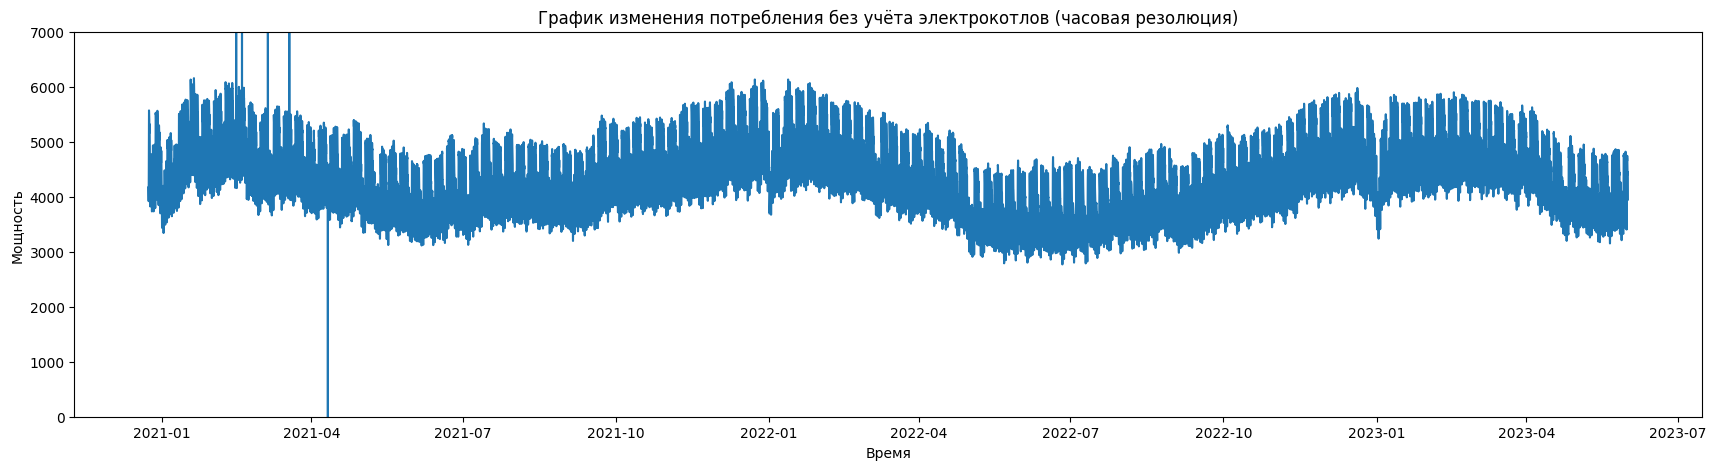

In [26]:
fig, ax = plt.subplots(figsize=(21, 5))

ax.plot(boiler_df['one_hour_consumption_without_boiler'])
ax.set_xlabel('Время')
ax.set_ylabel('Мощность')
ax.set_ylim([0, 7000])
ax.set_title('График изменения потребления без учёта электрокотлов (часовая резолюция)')

plt.show()

Рассчитаем часовые отконения на соседних интревалах:

In [27]:
df_diff = np.abs(boiler_df.diff())
df_diff.rename(columns={'one_hour_consumption_without_boiler': 'one_hour_consumption_without_boiler_diff'},
                        inplace=True)
df_diff.describe(percentiles=[.25, .75, .99, .999]).T

,count,mean,std,min,25%,50%,75%,99%,99.9%,max
one_hour_consumption_without_boiler_diff,21335.0,5.366597e+24,4.973367e+26,0.010588,36.084396,87.142633,180.298581,486.423209,566.580424,5.118915e+28


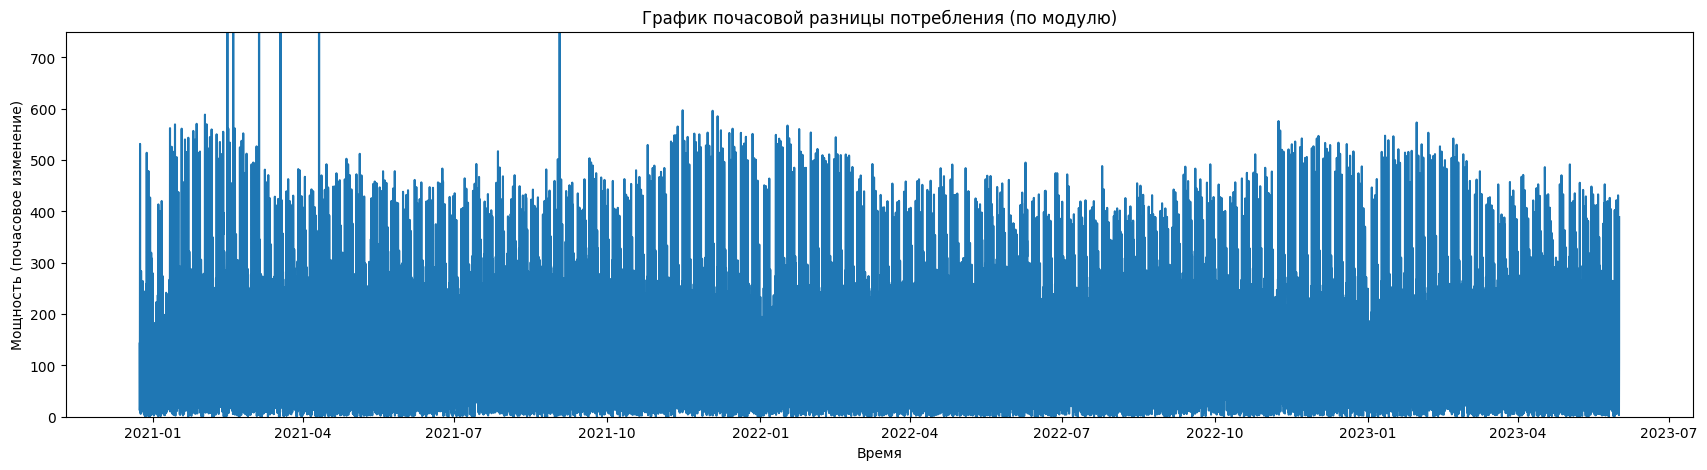

In [28]:
fig, ax = plt.subplots(figsize=(21, 5))

ax.plot(df_diff['one_hour_consumption_without_boiler_diff'])
ax.set_xlabel('Время')
ax.set_ylabel('Мощность (почасовое изменение)')
ax.set_ylim([0, 750])
ax.set_title('График почасовой разницы потребления (по модулю)')

plt.show()

Явные аномалии превышают 650 МВт, продолжительность - не более часа.

In [29]:
catch_time_series_outs(df=boiler_df,
                       col_name='one_hour_consumption_without_boiler',
                       min_diff=650,
                       time_delta=1,
                       freq='H')

Результат:

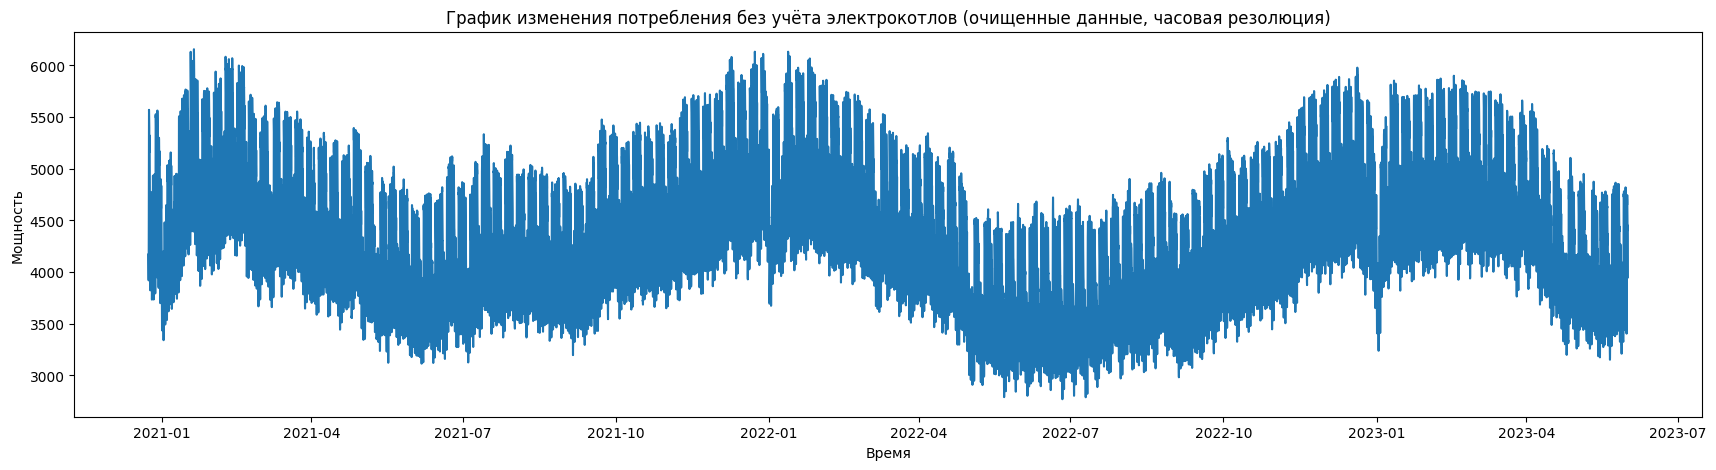

In [30]:
fig, ax = plt.subplots(figsize=(21, 5))

ax.plot(boiler_df['one_hour_consumption_without_boiler'])
ax.set_xlabel('Время')
ax.set_ylabel('Мощность')
ax.set_title('График изменения потребления без учёта электрокотлов (очищенные данные, часовая резолюция)')

plt.show()

In [31]:
for col_name, col_values in boiler_df.items():
    print(f"< {col_name} >".center(100, "-"))
    print(f"Data type: {col_values.dtype}")
    print(f"Is unique: {col_values.is_unique}")
    print(f"% of Nones: {col_values.isna().mean()}")
    print(col_values.describe(percentiles=(.01, .25, .75, .99)).round(2))

------------------------------< one_hour_consumption_without_boiler >-------------------------------
Data type: float64
Is unique: False
% of Nones: 0.0
count    21336.00
mean      4462.48
std        683.57
min       2768.79
1%        3045.64
25%       3969.98
50%       4446.15
75%       4972.04
99%       5836.70
max       6155.72
Name: one_hour_consumption_without_boiler, dtype: float64


In [32]:
boiler_df.head(2)

,one_hour_consumption_without_boiler
datetime,
2020-12-24 01:00:00,4169.466606
2020-12-24 02:00:00,4027.007811


Для совместимости данных у датафрейма boiler_df у индексов отнимем один час:

In [33]:
new_index = boiler_df.index
new_index -= pd.Timedelta(value=1, unit = 'H')
new_index

DatetimeIndex(['2020-12-24 00:00:00', '2020-12-24 01:00:00',
               '2020-12-24 02:00:00', '2020-12-24 03:00:00',
               '2020-12-24 04:00:00', '2020-12-24 05:00:00',
               '2020-12-24 06:00:00', '2020-12-24 07:00:00',
               '2020-12-24 08:00:00', '2020-12-24 09:00:00',
               ...
               '2023-05-31 14:00:00', '2023-05-31 15:00:00',
               '2023-05-31 16:00:00', '2023-05-31 17:00:00',
               '2023-05-31 18:00:00', '2023-05-31 19:00:00',
               '2023-05-31 20:00:00', '2023-05-31 21:00:00',
               '2023-05-31 22:00:00', '2023-05-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=21336, freq=None)

In [34]:
boiler_df.index = new_index
boiler_df.head(2)

,one_hour_consumption_without_boiler
datetime,
2020-12-24 00:00:00,4169.466606
2020-12-24 01:00:00,4027.007811


Наложим данные на графике:

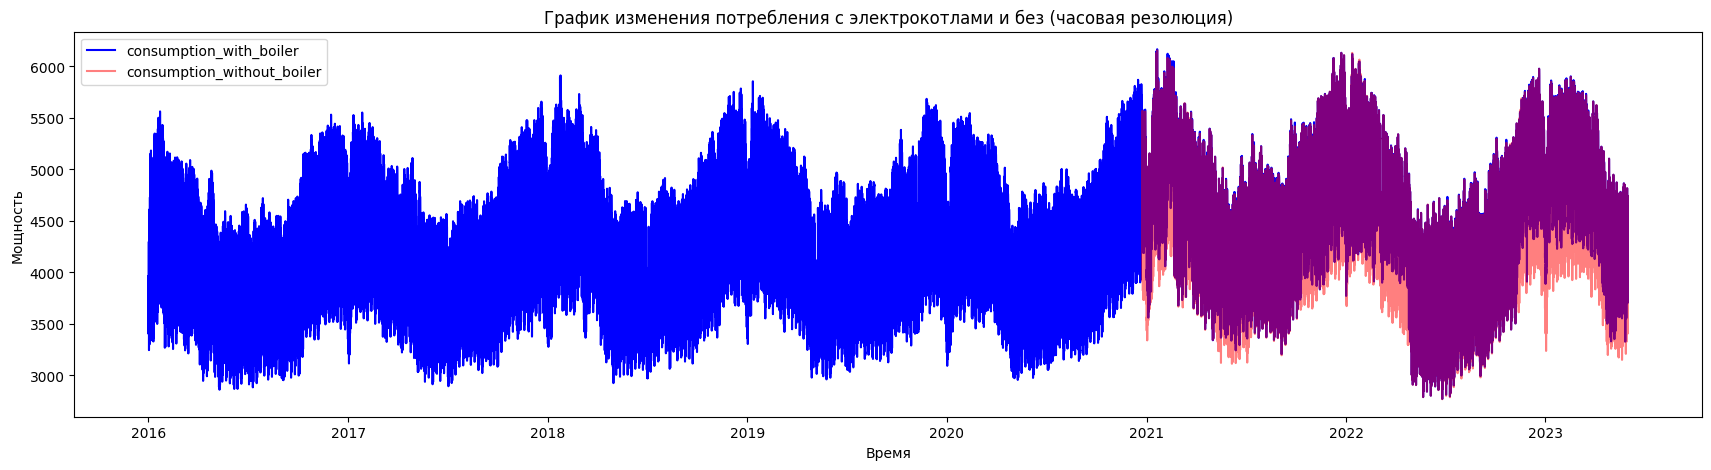

In [35]:
fig, ax = plt.subplots(figsize=(21, 5))

ax.plot(df['one_hour_consumption'], color='blue', label='consumption_with_boiler')
ax.plot(boiler_df['one_hour_consumption_without_boiler'], alpha=0.5, color='red', label='consumption_without_boiler')
ax.set_xlabel('Время')
ax.set_ylabel('Мощность')
ax.set_title('График изменения потребления с электрокотлами и без (часовая резолюция)')
ax.legend()

plt.show()

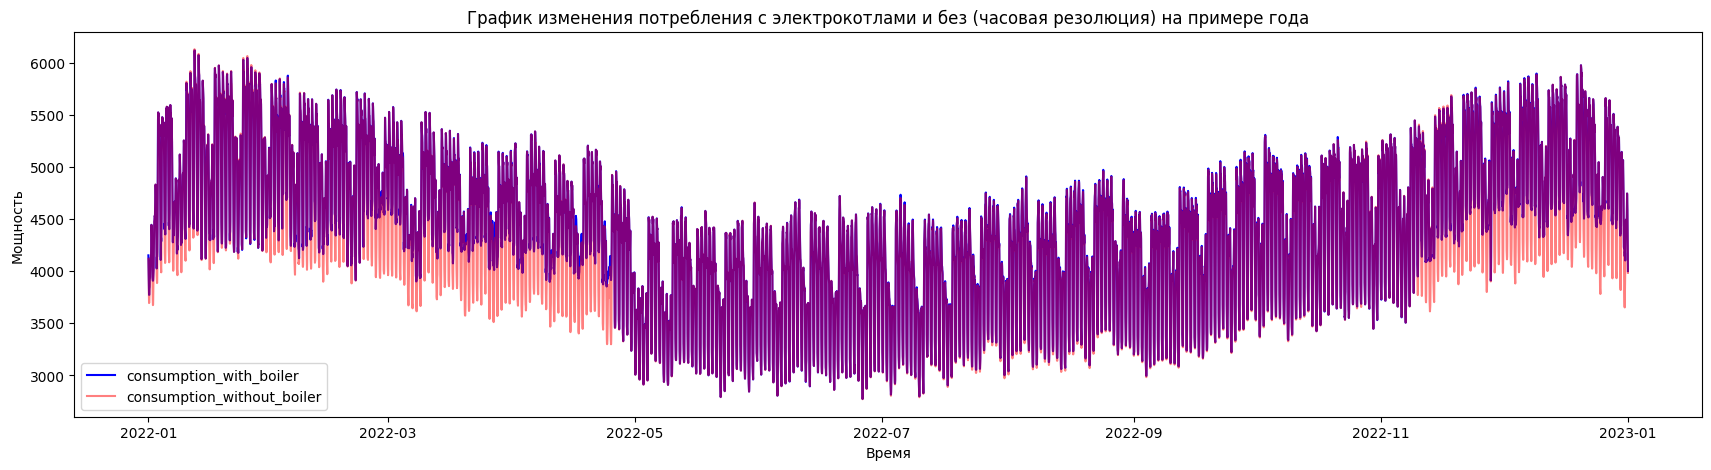

In [36]:
fig, ax = plt.subplots(figsize=(21, 5))

ax.plot(df.loc['2022', 'one_hour_consumption'], color='blue', label='consumption_with_boiler')
ax.plot(boiler_df.loc['2022', 'one_hour_consumption_without_boiler'], alpha=0.5, color='red', label='consumption_without_boiler')
ax.set_xlabel('Время')
ax.set_ylabel('Мощность')
ax.set_title('График изменения потребления с электрокотлами и без (часовая резолюция) на примере года')
ax.legend()

plt.show()

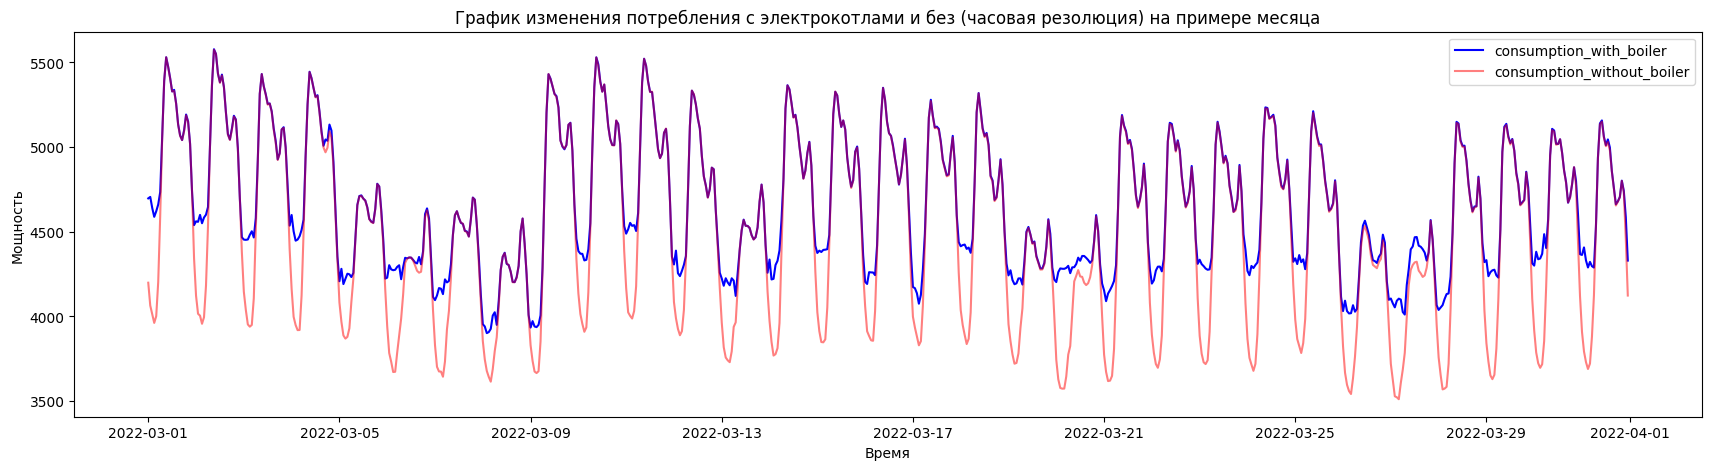

In [37]:
fig, ax = plt.subplots(figsize=(21, 5))

ax.plot(df.loc['2022-03', 'one_hour_consumption'], color='blue', label='consumption_with_boiler')
ax.plot(boiler_df.loc['2022-03', 'one_hour_consumption_without_boiler'], alpha=0.5, color='red', label='consumption_without_boiler')
ax.set_xlabel('Время')
ax.set_ylabel('Мощность')
ax.set_title('График изменения потребления с электрокотлами и без (часовая резолюция) на примере месяца')
ax.legend()

plt.show()

Включение электрокотлов происходит для увеличения потрбления в часы ночных минимумов. В часы максимальных нагрузок данные практически совпадают. В связи с этим, данные о потреблении начиная с 2018 года можно заменить часовыми интрегральными данными из второго датафрейма:

In [38]:
boiler_df.rename(columns={'one_hour_consumption_without_boiler': 'one_hour_consumption'},
                     inplace=True)

In [39]:
boiler_df.head(2)

,one_hour_consumption
datetime,
2020-12-24 00:00:00,4169.466606
2020-12-24 01:00:00,4027.007811


In [40]:
df.update(boiler_df)

In [41]:
df.head(2)

,one_hour_consumption,one_hour_temperature
datetime,,
2016-01-01 00:00:00,3962.983333,-8.313333
2016-01-01 01:00:00,3808.266667,-8.260000


Теперь мы имеем данные, готовые для обучения на них модели. Сохраним результат в csv файл.

In [42]:
df.to_csv('data_for_train/consumption_and_temperature_data.csv')